In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

## Load data

In [2]:
data = pd.read_csv("./data/Water_Quality/water_potability.csv", sep=",", header=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


## Duplicate and nul values

In [4]:
data.shape

(3276, 10)

In [5]:
print(data.duplicated().sum())

0


In [6]:
round(data.isnull().sum(axis=0)/3276 * 100)

ph                 15.0
Hardness            0.0
Solids              0.0
Chloramines         0.0
Sulfate            24.0
Conductivity        0.0
Organic_carbon      0.0
Trihalomethanes     5.0
Turbidity           0.0
Potability          0.0
dtype: float64

In [7]:
data.loc[:,["ph","Sulfate","Trihalomethanes"]].isnull().sum(0)

ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64

In [8]:
data = data.loc[-data.Trihalomethanes.isnull(),:]

In [9]:
data.loc[:,["ph","Sulfate"]].isnull().sum(0)

ph         465
Sulfate    741
dtype: int64

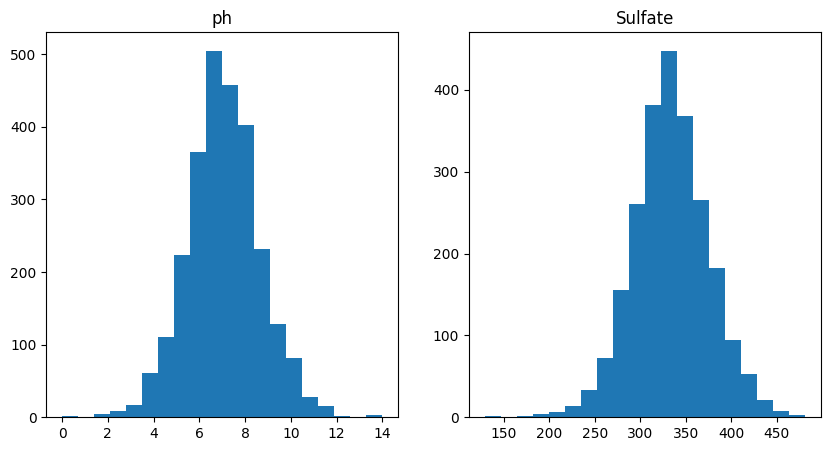

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(data.ph,bins=20)
ax[0].set_title("ph")
ax[1].hist(data.Sulfate,bins=20)
ax[1].set_title("Sulfate")
plt.show()

In [11]:
data.loc[data.ph.isnull(), "ph"] = np.random.normal(loc=np.mean(data.ph), 
                                                    scale=np.std(data.ph), 
                                                    size=465)

In [12]:
data.loc[data.Sulfate.isnull(), "Sulfate"] = np.random.normal(loc=np.mean(data.Sulfate), 
                                                    scale=np.std(data.Sulfate), 
                                                    size=741)

In [13]:
data.isnull().sum(axis=0)

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## Skewed

In [14]:
data.skew()

ph                 0.058932
Hardness          -0.020124
Solids             0.631585
Chloramines       -0.013148
Sulfate           -0.073232
Conductivity       0.266950
Organic_carbon     0.027011
Trihalomethanes   -0.083031
Turbidity         -0.022864
Potability         0.439467
dtype: float64

## Hypothesis

* Null hypothesis (H0): There is no difference in the mean of a numerical variable (for example, pH, hardness, TDS, etc.) between drinking water and non-potable water.
* Alternative hypothesis (H1): There is a difference in the mean of the numerical variable between drinking water and non-drinking water.

In [15]:
data["Potability"].replace(value=["potable", "no potable"], to_replace=[1,0], inplace=True)

/tmp/ipykernel_16507/1244267587.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Potability"].replace(value=["potable", "no potable"], to_replace=[1,0], inplace=True)


In [16]:
data.reset_index(inplace=True, drop=True)

In [17]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,8.374236,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,no potable
1,3.716080,129.422921,18630.057858,6.635246,269.283742,592.885359,15.180013,56.329076,4.500656,no potable
2,8.099124,224.236259,19909.541732,9.275884,423.099771,418.606213,16.868637,66.420093,3.055934,no potable
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,no potable
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,no potable


In [18]:
data.Potability.value_counts()

Potability
no potable    1891
potable       1223
Name: count, dtype: int64

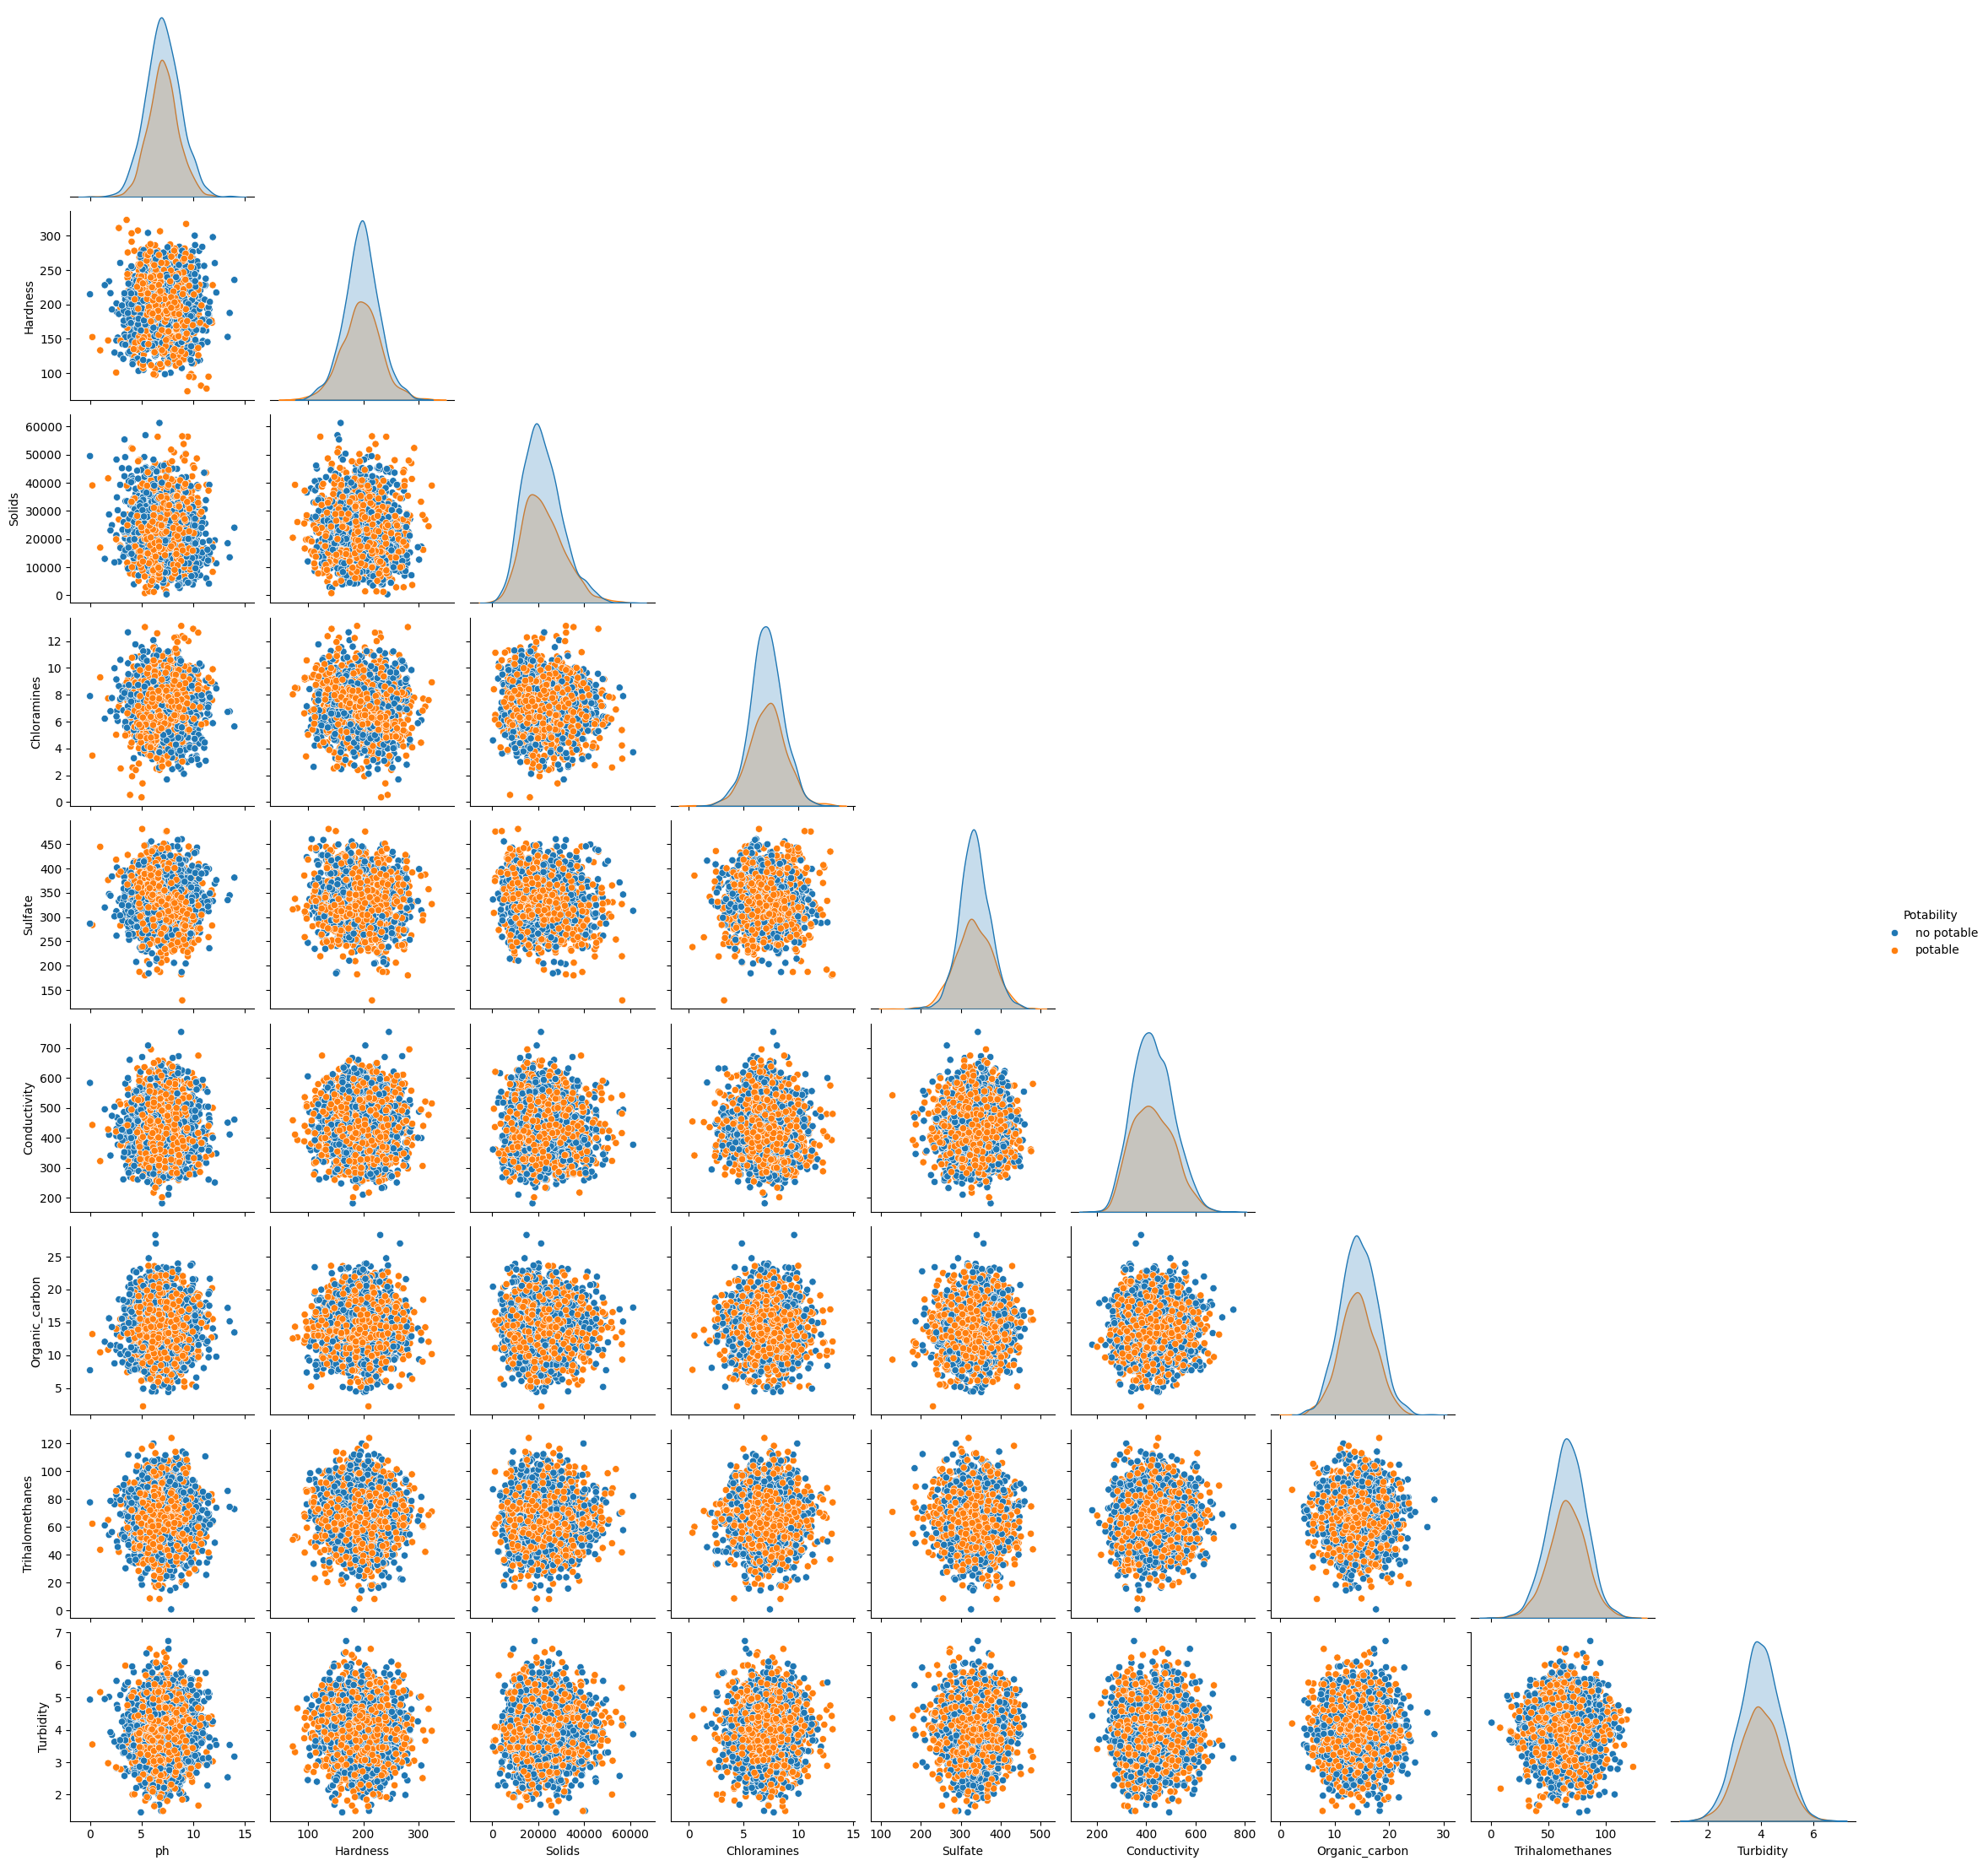

In [19]:
sns.pairplot(data=data, hue="Potability", corner=True)

In [20]:
X = data.drop(columns=["Potability"])

In [21]:
def perm_fun(x, nA, nB):
    n = nA+nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n))-idx_B
    idx_B = [i for i in idx_B]
    idx_A = [i for i in idx_A]
    return x.loc[idx_A].mean()-x.loc[idx_B].mean()

In [27]:
for i in X.columns.tolist():
    perm_diffs = [perm_fun(data[i], nA=1891, nB=1223) for _ in range(1000)]
    print(str(i)+ ":",np.mean(np.array(perm_diffs)>np.array([1891/3114-1223/3114])))
    print(np.sum(np.array(perm_diffs)>np.array([1891/3114-1223/3114])))

ph: 0.0
0
Hardness: 0.417
417
Solids: 0.505
505
Chloramines: 0.0
0
Sulfate: 0.47
470
Conductivity: 0.479
479
Organic_carbon: 0.037
37
Trihalomethanes: 0.361
361
Turbidity: 0.0
0
